# Instructions for cleaning dust data

This notebook contains all the steps necessary to clean the dust data collected by SKOMOBO units.

The cell below simply sets up this notebook environment with regards to libraries that will be used often, styling of the charts and tables and pulling in of the raw data extracted from the SKOMOBOS SD cards and the data stored on the 2 Dust track units that were deployed along side them.

In [70]:
# import the libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
from pylab import rcParams

# style the charts
rcParams['figure.figsize'] = 10, 5
rcParams['font.size'] = 20
rcParams['figure.dpi'] = 100
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'

# style the tables
pd.set_option("display.max_rows",15)
pd.set_option("display.max_columns",15)

# read all the CSV files one by one and store them in a list
dfs = []

for i in range(1, 8):
    dfs.append(pd.read_csv("../data/PM_estimation/SKOMOBO-dust" + str(i) +".csv", index_col=0, parse_dates=True))

# join up all the dataframes in the list into one huge dataframe
all_data = pd.concat(dfs)

# change the index so that it is based on the date and time and rearrange the columns so that equipment ID comes first
# variable and value
all_data = all_data.set_index(pd.DatetimeIndex(all_data.DT.values))[["EQM_ID", "variable", "value"]]

In [2]:
all_data

,EQM_ID,variable,value
2017-05-12 17:30:00,SKOMOBO,PM1.0,0.000
2017-05-12 17:31:00,SKOMOBO,PM1.0,0.000
2017-05-12 17:32:00,SKOMOBO,PM1.0,0.000
2017-05-12 17:33:00,SKOMOBO,PM1.0,0.000
2017-05-12 17:34:00,SKOMOBO,PM1.0,0.000
2017-05-12 17:35:00,SKOMOBO,PM1.0,0.000
2017-05-12 17:36:00,SKOMOBO,PM1.0,0.000
...,...,...,...
2017-07-13 11:54:00,PM10DT,PM10,0.038
2017-07-13 11:55:00,PM10DT,PM10,0.040


## Step 1 isolate the data

The dataframe shown above is all the data that was collected for all the units, in all 3 of the testing periods and sites, and is also mixed with PM1, PM2.5 and PM10. One Dust track was used to measure PM2.5 and the other was used to measure PM10. The Dust track dust sensors do not measure PM1 to my knowledge and so will not be included in these instructions. All the data in the above table is indexed using the date and time to make processing easier.

So in order to process it we need to isolate the data from the SKOMOBOS from the data collected by the dust tracks, and isolate the PM2.5 data from the PM10 data.

In [37]:
# extract the PM10 dustrack data and store it
DustTrackPM10 = all_data[all_data["EQM_ID"] == "PM10DT"]

# extract the PM2.5 dustrack data and store it
DustTrackPM2_5 = all_data[all_data["EQM_ID"] == "PM2.5DT"]

# create a list of box names like SKOMOBO, SKOMOBO1, SKOMOBO2 etc
ids = ["SKOMOBO"] + ["SKOMOBO" + str(i) for i in range(1, 8)]

# extract all the skomobos data
Skomobos = all_data[all_data["EQM_ID"].isin(ids)]

# isolate PM10 data and PM2.5 data
SkomoboPM10 = Skomobos[Skomobos["variable"] == "PM10"]
SkomoboPM2_5 = Skomobos[Skomobos["variable"] == "PM2.5"]

The data extracted by the Skomobo units is measured in micrograms per cubic metre, whilst the Dust track measures it in milligrams per cubic metre. So in order to be able to make a comparison we have to divide the values obtained by the SKOMOBOs by 1000.

In [38]:
SkomoboPM10["value"] = SkomoboPM10["value"] / 1000
SkomoboPM2_5["value"] = SkomoboPM2_5["value"] / 1000

C:\Users\Ryan\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Ryan\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Now we are going to merge the skomobo data and the dustrack data into a single table, wherein the skomobos get one column and the dustrack gets the other column.

Since we have recorded all the data on three seperate occasions and due to the fact that not all the dates and times of the units line up exactly, we have to make sure to isolate the values to only the ones where the dates and times line up. 

In [20]:
pd.DataFrame.join?

In [49]:
# join the dataframes
comparisonPM10 = SkomoboPM10.join(DustTrackPM10["value"], rsuffix="_dustrack").dropna()[["value", "value_dustrack"]]
comparisonPM2_5 = SkomoboPM2_5.join(DustTrackPM2_5["value"], rsuffix="_dustrack").dropna()[["value", "value_dustrack"]]

# change column names
comparisonPM10 = comparisonPM10.rename(columns={"value": "skomobo", "value_dustrack": "dustrack"})
comparisonPM2_5 = comparisonPM2_5.rename(columns={"value": "skomobo", "value_dustrack": "dustrack"})
comparisonPM10

,skomobo,dustrack
2017-05-12 17:31:00,0.000,0.011
2017-05-12 17:32:00,0.000,0.012
2017-05-12 17:33:00,0.000,0.013
2017-05-12 17:34:00,0.000,0.013
2017-05-12 17:35:00,0.001,0.012
2017-05-12 17:36:00,0.001,0.009
2017-05-12 17:37:00,0.001,0.011
...,...,...
2017-07-13 11:59:00,0.512,0.039
2017-07-13 12:00:00,19.712,0.036


The below plot visualizes the comparison for the PM10 data contained in the above table, followed by the PM2.5 data, over the time period the data was recorded

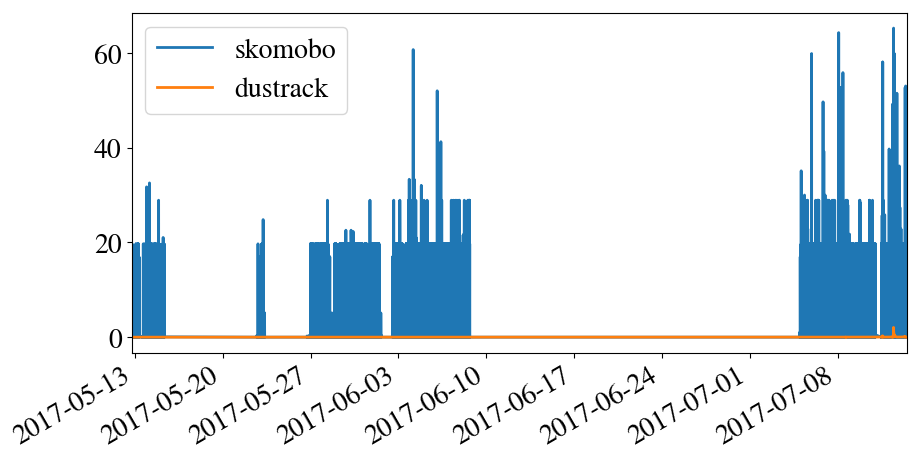

In [51]:
_ = comparisonPM10.plot()

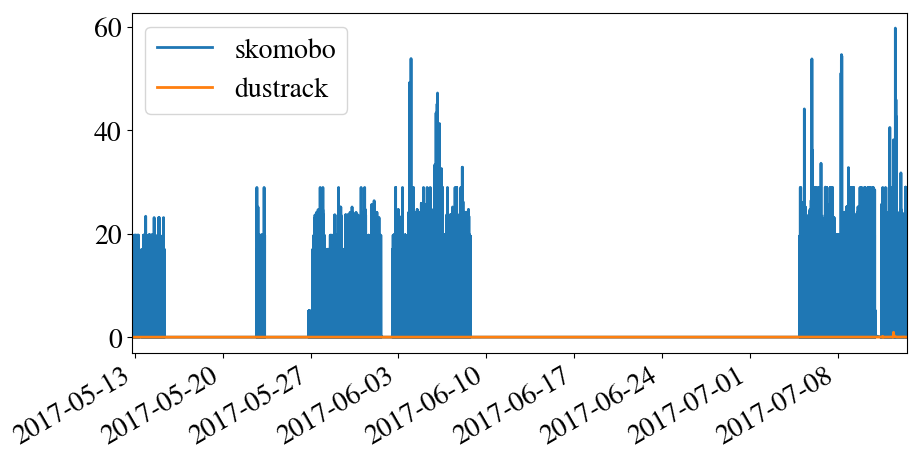

In [52]:
_ = comparisonPM2_5.plot()

Now we create a new column which contains this distance visualised above, by subtracting the values recorded by the skomobo from the values recorded by the dust track.

In [140]:
comparisonPM10["difference"] = comparisonPM10["skomobo"] - comparisonPM10["dustrack"]
comparisonPM2_5["difference"] = comparisonPM2_5["skomobo"] - comparisonPM2_5["dustrack"]
comparisonPM10

,skomobo,dustrack,difference
2017-05-12 17:31:00,0.000,0.011,-0.011
2017-05-12 17:32:00,0.000,0.012,-0.012
2017-05-12 17:33:00,0.000,0.013,-0.013
2017-05-12 17:34:00,0.000,0.013,-0.013
2017-05-12 17:35:00,0.001,0.012,-0.011
2017-05-12 17:36:00,0.001,0.009,-0.008
2017-05-12 17:37:00,0.001,0.011,-0.010
...,...,...,...
2017-07-13 11:59:00,0.512,0.039,0.473
2017-07-13 12:00:00,19.712,0.036,19.676


Based on the below scatterplot we can see that the difference recorded is quite large but really consistent, with a few outliers here and there.

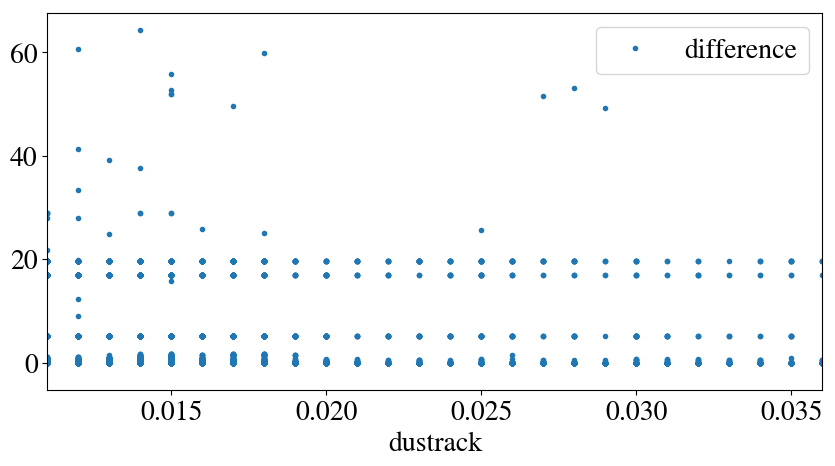

In [141]:
_ = comparisonPM10.plot(x= "dustrack", y="difference", style='.')

Now we will create a linear regression model to predict the above mentioned variation based on the skomobos values.
To validate our model we will use a train test split. This ensures that the model can predict new values it hasn't seen before. We will also use cross validation which randomly splits the data multiple times and performs the same test to validate the models accuracy.

In [142]:
# randomly split the data
trainPM10, testPM10 = train_test_split(comparisonPM10)
trainPM2_5, testPM2_5 = train_test_split(comparisonPM2_5)

# create the models
modelPM10 = LinearRegression().fit(trainPM10["skomobo"].values.reshape(-1,1), trainPM10["difference"].values.reshape(-1,1))
modelPM2_5 = LinearRegression().fit(trainPM2_5["skomobo"].values.reshape(-1,1), trainPM2_5["difference"].values.reshape(-1,1))

Now we will check the accuracy of the model using the R squared coeffecient metric

In [143]:
print "PM10 training accuracy: " + str(modelPM10.score(trainPM10["skomobo"].values.reshape(-1,1), trainPM10["difference"].values.reshape(-1,1)) * 100) + "%"
print "PM2.5 training accuracy: " + str(modelPM2_5.score(trainPM2_5["skomobo"].values.reshape(-1,1), trainPM2_5["difference"].values.reshape(-1,1)) * 100) + "%"
print "PM10 testing accuracy: " + str(modelPM10.score(testPM10["skomobo"].values.reshape(-1,1), testPM10["difference"].values.reshape(-1,1)) * 100) + "%"
print "PM2.5 testing accuracy: " + str(modelPM2_5.score(testPM2_5["skomobo"].values.reshape(-1,1), testPM2_5["difference"].values.reshape(-1,1)) * 100) + "%"

PM10 training accuracy: 99.9848811508%
PM2.5 training accuracy: 99.9969980875%
PM10 testing accuracy: 99.9858234666%
PM2.5 testing accuracy: 99.9972882828%


The above models have a nearly 100% accuracy. This is fantastic however these predictions are useless on their own.
In order to get useful information out of them we have to subtract the predicted value from the original value retreived by the SKOMOBO, in order to calibrate it to line up with the values produced by the dust track.

In [144]:
trainPM10["predicted_difference"] = modelPM10.predict(trainPM10["skomobo"].values.reshape(-1,1))
trainPM2_5["predicted_difference"] = modelPM2_5.predict(trainPM2_5["skomobo"].values.reshape(-1,1))
testPM10["predicted_difference"] = modelPM10.predict(testPM10["skomobo"].values.reshape(-1,1))
testPM2_5["predicted_difference"] = modelPM2_5.predict(testPM2_5["skomobo"].values.reshape(-1,1))

C:\Users\Ryan\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Ryan\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Ryan\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [145]:
trainPM10["prediction"] = trainPM10["skomobo"] - trainPM10["predicted_difference"]
trainPM2_5["prediction"] = trainPM2_5["skomobo"] - trainPM2_5["predicted_difference"]
testPM10["prediction"] = testPM10["skomobo"] - testPM10["predicted_difference"]
testPM2_5["prediction"] = testPM2_5["skomobo"] - testPM2_5["predicted_difference"]

C:\Users\Ryan\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Ryan\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Ryan\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

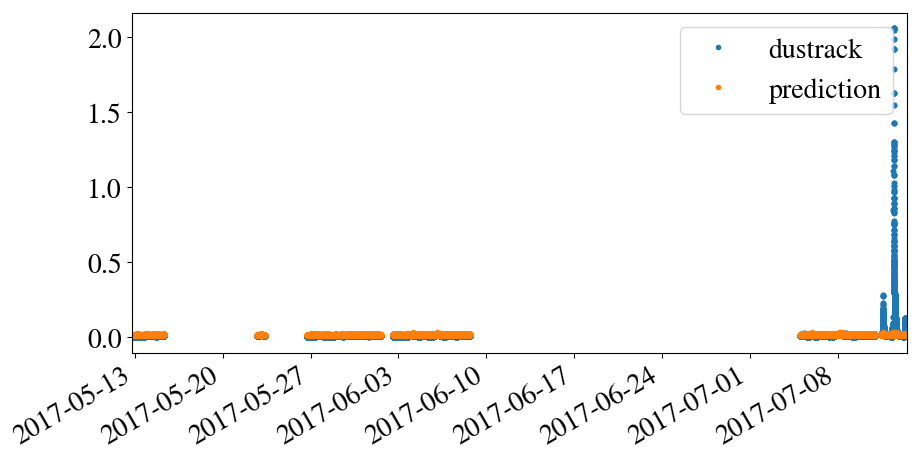

In [146]:
trainPM10[["dustrack", "prediction"]].plot(style = '.')

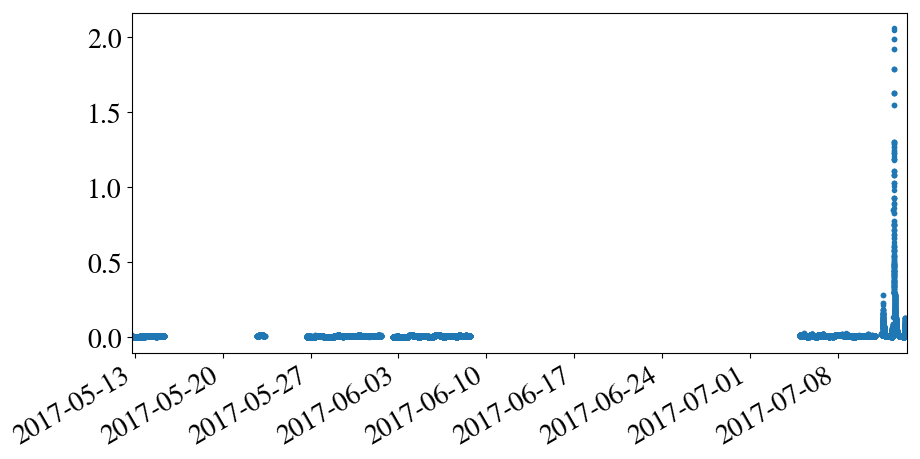

In [147]:
testPM10["dustrack"].plot(style='.')

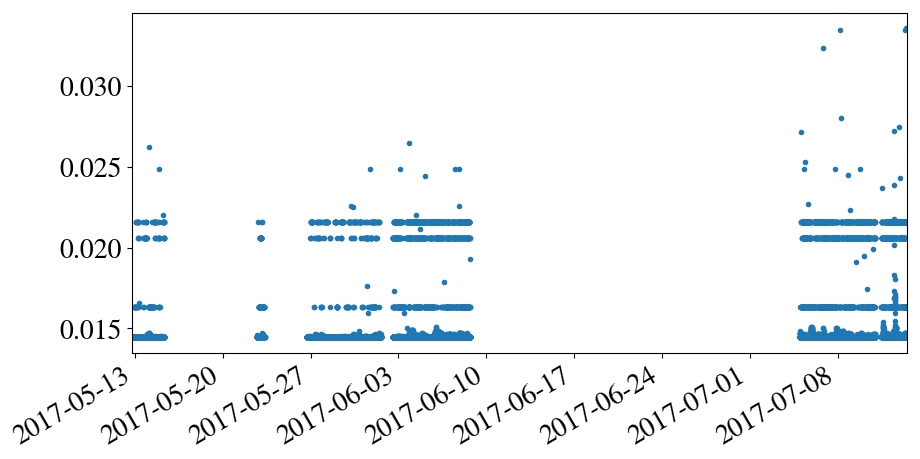

In [148]:
testPM10["prediction"].plot(style='.')